In [1]:
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt

In [2]:
@torch.no_grad()
def generate_image(model, x_t, T = 300):
    beta = torch.linspace(1e-4, 2e-2, T).cuda()
    alpha = (1-beta).cuda()
    alpha_cumprod = torch.cumprod(alpha, dim=0).cuda()
    #alpha_cumprod = torch.cos(torch.linspace(0, 3.1415/2, T))

    for t in reversed(range(T)):
        x_t = timestep(model, x_t, t, beta, alpha, alpha_cumprod)
    return x_t


@torch.no_grad()
def timestep(model, x_t, t, beta, alpha, alpha_cumrpod):
    if t==0:
        z = torch.zeros_like(x_t).cuda()
    else:
        z = torch.randn_like(x_t).cuda()
    sigma_t = beta[t].cuda()
    model_coeff = ((1-alpha[t])/torch.sqrt(1-alpha_cumrpod[t])).cuda()
    main_coeff = (1/torch.sqrt(alpha[t])).cuda()
    noise = model(x_t, torch.tensor([t]).cuda())
    #print(model_coeff)
    #print(main_coeff)
    return main_coeff*(x_t-model_coeff*noise)+sigma_t*z


In [3]:
class Level(nn.Module):
    def __init__(self, inch, och, dim):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(inch)
        self.conv1 = nn.Conv2d(inch, och, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(och)
        self.conv2 = nn.Conv2d(och, och, 3, 1, 1)
        self.act = nn.ReLU()
        self.time_embedding = nn.Sequential(
            Sinusoidal_embedding(dim),
            nn.Linear(dim, och),
            nn.ReLU()
        )
    
    def __call__(self, x, t):
        return self.forward(x, t)
    
    def forward(self, x, t):
        x = self.bn1(x)
        x = self.conv1(x)
        x = self.act(x)

        #embedding = self.time_embedding(t)
        #embedding = embedding[(..., ) + (None, ) * 2]
        #x = x+embedding

        x = self.bn2(x)
        x = self.conv2(x)
        x = self.act(x)

        return x

class Upconv(nn.Module):
    def __init__(self, inch, och):
        super().__init__()
        self.bn = nn.BatchNorm2d(inch)
        self.conv = nn.ConvTranspose2d(inch, och, 2, 2)
        self.act = nn.ReLU()

    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        x = self.act(x)

        return x
    
class Sinusoidal_embedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def __call__(self, t):
        return self.forward(t)
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim//2
        exp_sin = torch.linspace(0, 1, half_dim, device=device)
        exp_cos = torch.linspace(0, 1, half_dim, device=device)
        exp_sin = torch.sin(t*10000**exp_sin)
        exp_cos = torch.cos(t*10000**exp_cos)
        embedding = torch.cat((exp_sin, exp_cos), dim=-1)
        return embedding


class Unet(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.downlevel1 = Level(3, 64, dim)
        self.downlevel2 = Level(64, 128, dim)
        self.downlevel3 = Level(128, 256, dim)
        self.downlevel4 = Level(256, 512, dim)
        self.downlevel5 = Level(512, 1024, dim)
        self.uplevel1 = Level(1024, 512, dim)
        self.uplevel2 = Level(512, 256, dim)
        self.uplevel3 = Level(256, 128, dim)
        self.uplevel4 = Level(128, 64, dim)
        self.pool = nn.MaxPool2d(2, 2)
        self.upconv1 = Upconv(1024, 512)
        self.upconv2 = Upconv(512, 256)
        self.upconv3 = Upconv(256, 128)
        self.upconv4 = Upconv(128, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.lastconv = nn.Conv2d(64, 3, 1)
        self.bn2 = nn.BatchNorm2d(3)
        self.act = nn.Sigmoid()
    
    def __call__(self, x, t):
        return self.forward(x, t)
    
    def forward(self, x, t):
        x = self.downlevel1(x, t)
        residual1 = x
        x = self.pool(x)
        
        x = self.downlevel2(x, t)
        residual2 = x
        x = self.pool(x)

        x = self.downlevel3(x, t)
        residual3 = x
        x = self.pool(x)

        x = self.downlevel4(x, t)
        residual4 = x
        x = self.pool(x)

        x = self.downlevel5(x, t)

        x = self.upconv1(x)
        x = torch.cat([residual4, x], 1)
        x = self.uplevel1(x, t)

        x = self.upconv2(x)
        x = torch.cat([residual3, x], 1)
        x = self.uplevel2(x, t)
        
        x = self.upconv3(x)
        x = torch.cat([residual2, x], 1)
        x = self.uplevel3(x, t)

        x = self.upconv4(x)
        x = torch.cat([residual1, x], 1)
        x = self.uplevel4(x, t)

        x = self.bn1(x)
        x = self.lastconv(x)
        #x = self.bn2(x)
        #x = self.act(x)

        return x

In [4]:
def min_max_scale(x):
    return (x-torch.min(x))/(torch.max(x)-torch.min(x))

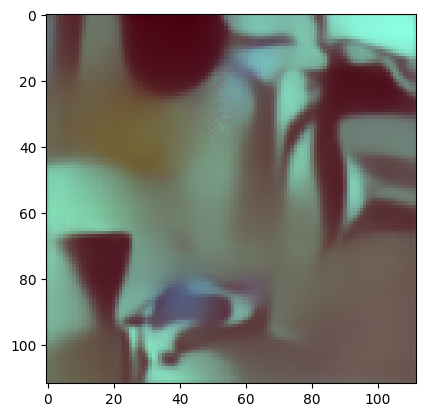

In [6]:
model_path = "./model_celeb.pt"
model = Unet(32).cuda()
model.load_state_dict(torch.load(model_path, weights_only=True))
x = torch.randn(1, 3, 112, 112).cuda()
x_0 = generate_image(model, x)
y = min_max_scale(x_0)
y = (y.cpu().detach())[0].permute(1, 2, 0)
plt.imshow(y)